# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with fewer neurons.  
Train on copious simulated data.  
Use uniform but realistic RNA lengths.  

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-16 09:10:55 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=1000  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-16 09:10:56.280106: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import Collection_Generator, Transcript_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.RNA_gen import Collection_Generator, Transcript_Oracle
        from SimTools.KmerTools import KmerTools
BESTMODELPATH=DATAPATH+"BestModel"  # saved on cloud instance and lost after logout
LASTMODELPATH=DATAPATH+"LastModel"  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-16 09:10:56 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequence characteristics:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1000.0
Average ORF length: 674.9937272727273
NC seqs
Average RNA length: 1000.0
Average ORF length: 179.6726181818182
2021-08-16 09:11:18 EDT


## Data Prep

In [7]:
def combine_pos_and_neg(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    return X,y
Xseq,y=combine_pos_and_neg(pc_all,nc_all)
print("The first few shuffled labels:")
print(y[:30])
pc_all=None
nc_all=None
show_time()

The first few shuffled labels:
[0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0]
2021-08-16 09:11:18 EDT


In [8]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    collection = []
    debug = 0
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
        if (debug<3):
            print(fdict)
            debug += 1;
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print("First few K-mer frequency matrices:")
print(Xfrq[:3])
Xseq = None
show_time()

{'A': 0.229, 'C': 0.29, 'G': 0.247, 'T': 0.234, 'AA': 0.055055055055055056, 'AC': 0.06906906906906907, 'AG': 0.05305305305305305, 'AT': 0.05205205205205205, 'CA': 0.05805805805805806, 'CC': 0.09009009009009009, 'CG': 0.07407407407407407, 'CT': 0.06806806806806807, 'GA': 0.057057057057057055, 'GC': 0.06706706706706707, 'GG': 0.06606606606606606, 'GT': 0.057057057057057055, 'TA': 0.05905905905905906, 'TC': 0.06306306306306306, 'TG': 0.05405405405405406, 'TT': 0.057057057057057055, 'AAA': 0.011022044088176353, 'AAC': 0.013026052104208416, 'AAG': 0.017034068136272545, 'AAT': 0.014028056112224449, 'ACA': 0.01503006012024048, 'ACC': 0.022044088176352707, 'ACG': 0.02004008016032064, 'ACT': 0.012024048096192385, 'AGA': 0.012024048096192385, 'AGC': 0.013026052104208416, 'AGG': 0.018036072144288578, 'AGT': 0.01002004008016032, 'ATA': 0.01503006012024048, 'ATC': 0.013026052104208416, 'ATG': 0.008016032064128256, 'ATT': 0.01603206412825651, 'CAA': 0.011022044088176353, 'CAC': 0.021042084168336674,

In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-16 09:11:41 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2720      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-16 09:11:41.489876: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 09:11:41.552482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 09:11:41.552974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-16 09:11:41.553004: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 09:11:41.556060: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 09:11:41.556107: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-16 09:11:41 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-16 09:11:42.108199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 09:11:42.128234: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-16 09:11:48.519501: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 155/2084 [=>............................] - ETA: 1s - loss: 0.7192 - accuracy: 0.5092 

2021-08-16 09:11:48.838960: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 9s 1ms/step - loss: 0.7045 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5049


2021-08-16 09:11:51.834858: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6940 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6934 - val_accuracy: 0.4951
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5049
Epoch 8/200
2084/2084 [==============================] - 3s 1ms/step - lo

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5776 - accuracy: 0.6982 - val_loss: 0.5451 - val_accuracy: 0.7256
Epoch 46/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5764 - accuracy: 0.6991 - val_loss: 0.5482 - val_accuracy: 0.7250
Epoch 47/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5745 - accuracy: 0.7005 - val_loss: 0.5469 - val_accuracy: 0.7270
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 48/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5754 - accuracy: 0.6989 - val_loss: 0.5480 - val_accuracy: 0.7262
Epoch 49/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5764 - accuracy: 0.6990 - val_loss: 0.5438 - val_accuracy: 0.7270
Epoch 50/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5777 - accuracy: 0.6975 - val_loss: 0.5427 - val_accuracy: 0.7272
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 51/200
2084/2084 

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5567 - accuracy: 0.7145 - val_loss: 0.5321 - val_accuracy: 0.7330
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 96/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5602 - accuracy: 0.7084 - val_loss: 0.5332 - val_accuracy: 0.7322
Epoch 97/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5564 - accuracy: 0.7146 - val_loss: 0.5312 - val_accuracy: 0.7333
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 98/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5556 - accuracy: 0.7143 - val_loss: 0.5325 - val_accuracy: 0.7324
Epoch 99/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5564 - accuracy: 0.7146 - val_loss: 0.5308 - val_accuracy: 0.7328
Epoch 100/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.5541 - accuracy: 0.7162 - val_loss: 0.5302 - val_accuracy: 0.7324
Epoch 101/200
2084/208

Epoch 148/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5503 - accuracy: 0.7206 - val_loss: 0.5287 - val_accuracy: 0.7346
Epoch 149/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5496 - accuracy: 0.7207 - val_loss: 0.5281 - val_accuracy: 0.7343
Epoch 150/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5494 - accuracy: 0.7181 - val_loss: 0.5292 - val_accuracy: 0.7345
Epoch 151/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5470 - accuracy: 0.7223 - val_loss: 0.5285 - val_accuracy: 0.7343
Epoch 152/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5516 - accuracy: 0.7162 - val_loss: 0.5288 - val_accuracy: 0.7343
Epoch 153/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5491 - accuracy: 0.7187 - val_loss: 0.5276 - val_accuracy: 0.7345
Epoch 154/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5522 - accuracy: 0.7178 - val_loss: 0

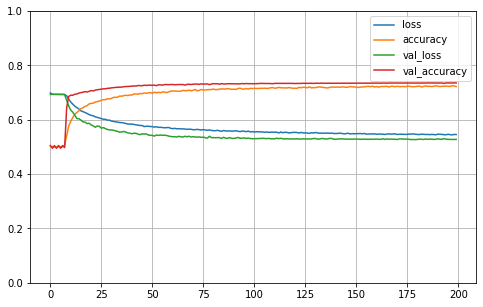

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7030 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5064 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6928 - accuracy: 0.5113 - val_loss: 0.6877 - val_accuracy: 0.5591
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6878 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5673 - accuracy: 0.7080 - val_loss: 0.5409 - val_accuracy: 0.7264
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5658 - accuracy: 0.7054 - val_loss: 0.5419 - val_accuracy: 0.7266
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5708 - accuracy: 0.7042 - val_loss: 0.5403 - val_accuracy: 0.7271
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5675 - accuracy: 0.7060 - val_loss: 0.5392 - val_accuracy: 0.7271
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5677 - accuracy: 0.7047 - val_loss: 0.5391 - val_accuracy: 0.7272
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5642 - accuracy: 0.7079 - val_loss: 0.5409 - val_accuracy: 0.7276
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5639 - accuracy: 0.7119 - val_loss: 0.5386 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5501 - accuracy: 0.7227 - val_loss: 0.5331 - val_accuracy: 0.7310
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5507 - accuracy: 0.7195 - val_loss: 0.5334 - val_accuracy: 0.7288
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5521 - accuracy: 0.7198 - val_loss: 0.5333 - val_accuracy: 0.7310
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5546 - accuracy: 0.7142 - val_loss: 0.5322 - val_accuracy: 0.7310
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5487 - accuracy: 0.7200 - val_loss: 0.5348 - val_accuracy: 0.7311
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5525 - accuracy: 0.7192 - val_loss: 0.5337 - val_accuracy: 0.7312
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5529 - accuracy: 0.7178 - val_loss: 0.5316 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5476 - accuracy: 0.7209 - val_loss: 0.5314 - val_accuracy: 0.7318
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5443 - accuracy: 0.7257 - val_loss: 0.5301 - val_accuracy: 0.7319
Epoch 171/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5457 - accuracy: 0.7239 - val_loss: 0.5304 - val_accuracy: 0.7319
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5447 - accuracy: 0.7248 - val_loss: 0.5306 - val_accuracy: 0.7319
Epoch 173/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5472 - accuracy: 0.7237 - val_loss: 0.5312 - val_accuracy: 0.7317
Epoch 174/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5436 - accuracy: 0.7226 - val_loss: 0.5303 - val_accuracy: 0.7315
Epoch 175/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5441 - accuracy: 0.7233 - val_loss: 0

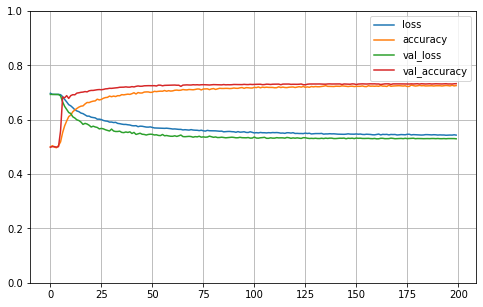

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7112 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5032
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6937 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5032
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.4968
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6934 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5032
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5045 - val_loss: 0.6929 - val_accuracy: 0.5567
Epoch 6/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6927 - accuracy: 0.5140 - val_loss: 0.6856 - val_accuracy: 0.5137
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6867 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5676 - accuracy: 0.7048 - val_loss: 0.5371 - val_accuracy: 0.7300
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5681 - accuracy: 0.7055 - val_loss: 0.5411 - val_accuracy: 0.7295
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5705 - accuracy: 0.7019 - val_loss: 0.5403 - val_accuracy: 0.7294
Epoch 60/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5699 - accuracy: 0.7038 - val_loss: 0.5382 - val_accuracy: 0.7297
Epoch 61/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5683 - accuracy: 0.7034 - val_loss: 0.5366 - val_accuracy: 0.7308
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5665 - accuracy: 0.7053 - val_loss: 0.5408 - val_accuracy: 0.7312
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5672 - accuracy: 0.7035 - val_loss: 0.5368 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.5548 - accuracy: 0.7163 - val_loss: 0.5289 - val_accuracy: 0.7354
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 113/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5524 - accuracy: 0.7185 - val_loss: 0.5285 - val_accuracy: 0.7355
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5556 - accuracy: 0.7125 - val_loss: 0.5297 - val_accuracy: 0.7353
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5537 - accuracy: 0.7159 - val_loss: 0.5299 - val_accuracy: 0.7357
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5534 - accuracy: 0.7156 - val_loss: 0.5301 - val_accuracy: 0.7355
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5523 - accuracy: 0.7172 - v

Epoch 164/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5473 - accuracy: 0.7198 - val_loss: 0.5284 - val_accuracy: 0.7364
Epoch 165/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5494 - accuracy: 0.7195 - val_loss: 0.5261 - val_accuracy: 0.7367
Epoch 166/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5485 - accuracy: 0.7210 - val_loss: 0.5261 - val_accuracy: 0.7373
Epoch 167/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5512 - accuracy: 0.7189 - val_loss: 0.5265 - val_accuracy: 0.7373
Epoch 168/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5462 - accuracy: 0.7214 - val_loss: 0.5265 - val_accuracy: 0.7370
Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5463 - accuracy: 0.7211 - val_loss: 0.5266 - val_accuracy: 0.7354
Epoch 170/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.5504 - accuracy: 0.7199 - val_loss: 0

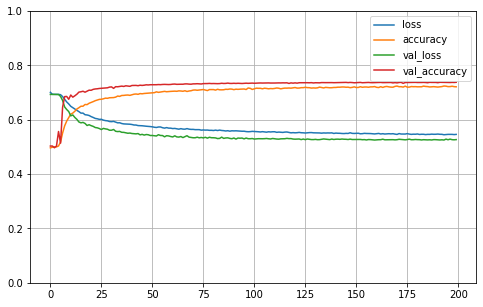

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [15]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-16 10:15:13 EDT


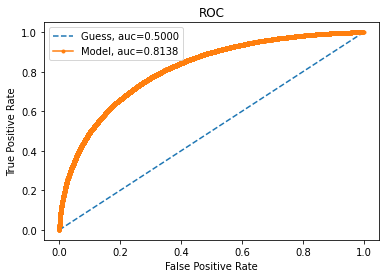

AUC: 81.38%
accuracy: 73.48%
2021-08-16 10:15:15 EDT


In [17]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-16 10:15:17 EDT


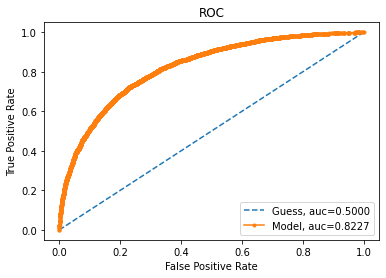

AUC: 82.27%
accuracy: 74.30%
2021-08-16 10:15:18 EDT


In [18]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(last_model,X_test,y_test)
show_time()